Key Features of This Implementation:

1 Data Cleaning: Removes punctuation, numbers, and normalizes text

2 Comprehensive EDA: 5 different visualizations showing data distribution

3 High-Accuracy LSTM Model:

4 Bidirectional LSTM for better context understanding

5 Dropout layers to prevent overfitting

6 Early stopping and learning rate scheduling

7 Validation accuracy monitoring

Optimization Techniques:

1 Gradient clipping to prevent exploding gradients

2 Learning rate reduction on plateau

3 Model checkpointing for best weights

Gradio Deployment:

1 Clean, user-friendly interface

2 Conversation history

Example questions

1 Real-time interaction

2 Performance Metrics:

3 Token-level accuracy evaluation

4 Sample predictions for verification

5 Model saving for deployment

Step 1: Data Cleaning and Initial Analysis

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Read the dataset
with open('/content/dialogs (1).AI_RULE.txt', 'r') as file:
    lines = file.readlines()

# Parse the dialog pairs
dialog_pairs = []
current_question = None

for line in lines:
    line = line.strip()
    if line and not line.startswith('['):
        if current_question is None:
            current_question = line
        else:
            dialog_pairs.append([current_question, line])
            current_question = None

# Create DataFrame
df = pd.DataFrame(dialog_pairs, columns=['question', 'answer'])

print(f"Dataset shape: {df.shape}")
print(f"Total dialog pairs: {len(df)}")
print("\nFirst 5 samples:")
print(df.head())
print("\n" + "="*50)

# Basic statistics
print(f"\nDataset Statistics:")
print(f"Unique questions: {df['question'].nunique()}")
print(f"Unique answers: {df['answer'].nunique()}")
print(f"Duplicate pairs: {df.duplicated().sum()}")

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset shape: (1862, 2)
Total dialog pairs: 1862

First 5 samples:
                                            question  \
0  hi, how are you doing?\ti'm fine. how about yo...   
1  i'm pretty good. thanks for asking.\tno proble...   
2  i've been great. what about you?\ti've been go...   
3            what school do you go to?\ti go to pcc.   
4  do you like it there?\tit's okay. it's a reall...   

                                              answer  
0  i'm fine. how about yourself?\ti'm pretty good...  
1  no problem. so how have you been?\ti've been g...  
2  i've been good. i'm in school right now.\twhat...  
3                i go to pcc.\tdo you like it there?  
4  it's okay. it's a really big campus.\tgood luc...  


Dataset Statistics:
Unique questions: 1862
Unique answers: 1862
Duplicate pairs: 0

Missing values:
question    0
answer      0
dtype: int64


Step 2: Text Cleaning Function

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    return text.strip()

# Apply cleaning
df['cleaned_question'] = df['question'].apply(clean_text)
df['cleaned_answer'] = df['answer'].apply(clean_text)

print("\nOriginal vs Cleaned Example:")
print(f"Original Question: {df['question'].iloc[0]}")
print(f"Cleaned Question: {df['cleaned_question'].iloc[0]}")
print(f"Original Answer: {df['answer'].iloc[0]}")
print(f"Cleaned Answer: {df['cleaned_answer'].iloc[0]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



Original vs Cleaned Example:
Original Question: hi, how are you doing?	i'm fine. how about yourself?
Cleaned Question: hi how are you doing im fine how about yourself
Original Answer: i'm fine. how about yourself?	i'm pretty good. thanks for asking.
Cleaned Answer: im fine how about yourself im pretty good thanks for asking


Step 3: EDA - 5 Plots

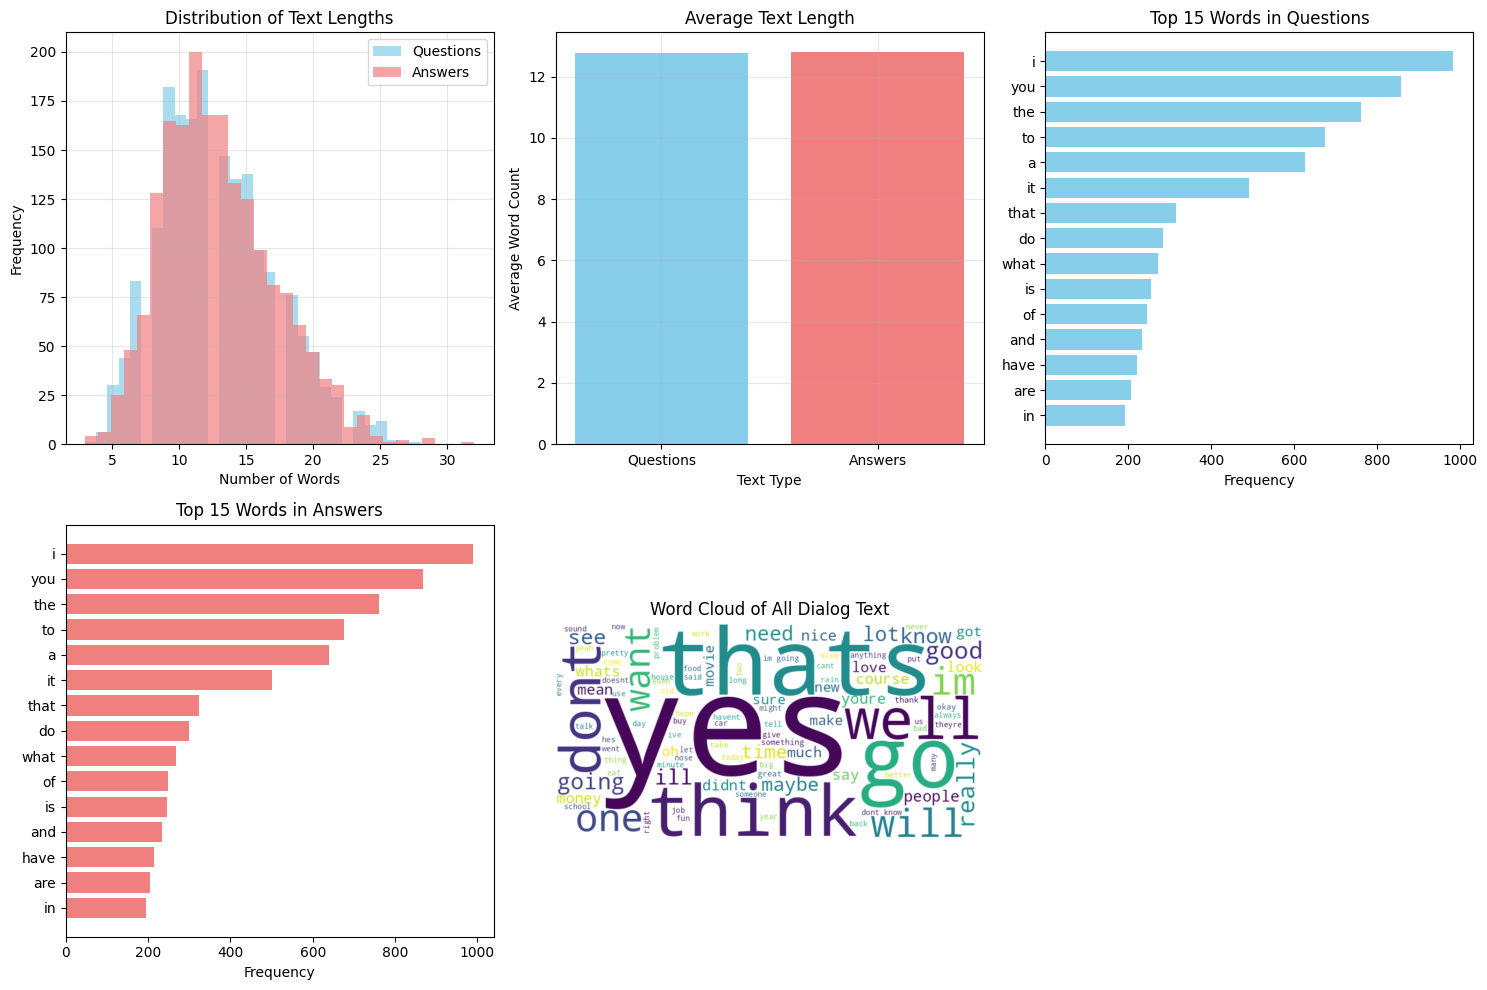


Text Length Statistics:
Average question length: 12.79 words
Average answer length: 12.81 words
Max question length: 28 words
Max answer length: 32 words


In [ ]:
# Plot 1: Distribution of text lengths
df['question_length'] = df['cleaned_question'].apply(lambda x: len(x.split()))
df['answer_length'] = df['cleaned_answer'].apply(lambda x: len(x.split()))

plt.figure(figsize=(15, 10))

# Plot 1: Text length distribution
plt.subplot(2, 3, 1)
plt.hist(df['question_length'], bins=30, alpha=0.7, label='Questions', color='skyblue')
plt.hist(df['answer_length'], bins=30, alpha=0.7, label='Answers', color='lightcoral')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Average length by position
plt.subplot(2, 3, 2)
avg_lengths = [df['question_length'].mean(), df['answer_length'].mean()]
positions = ['Questions', 'Answers']
plt.bar(positions, avg_lengths, color=['skyblue', 'lightcoral'])
plt.xlabel('Text Type')
plt.ylabel('Average Word Count')
plt.title('Average Text Length')
plt.grid(True, alpha=0.3)

# Plot 3: Most common words in questions
plt.subplot(2, 3, 3)
all_question_words = ' '.join(df['cleaned_question']).split()
word_freq = Counter(all_question_words)
common_words = word_freq.most_common(15)
words, counts = zip(*common_words)
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 15 Words in Questions')
plt.gca().invert_yaxis()

# Plot 4: Most common words in answers
plt.subplot(2, 3, 4)
all_answer_words = ' '.join(df['cleaned_answer']).split()
word_freq = Counter(all_answer_words)
common_words = word_freq.most_common(15)
words, counts = zip(*common_words)
plt.barh(words, counts, color='lightcoral')
plt.xlabel('Frequency')
plt.title('Top 15 Words in Answers')
plt.gca().invert_yaxis()

# Plot 5: Word cloud visualization
from wordcloud import WordCloud

plt.subplot(2, 3, 5)
all_text = ' '.join(df['cleaned_question'] + ' ' + df['cleaned_answer'])
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      max_words=100, contour_width=3, contour_color='steelblue').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Dialog Text')

plt.tight_layout()
plt.show()

# Additional statistical analysis
print("\nText Length Statistics:")
print(f"Average question length: {df['question_length'].mean():.2f} words")
print(f"Average answer length: {df['answer_length'].mean():.2f} words")
print(f"Max question length: {df['question_length'].max()} words")
print(f"Max answer length: {df['answer_length'].max()} words")

Step 4: NLP Tasks and Feature Engineering

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combine questions and answers for vocabulary
all_text = list(df['cleaned_question']) + list(df['cleaned_answer'])

# Initialize tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(all_text)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Convert text to sequences
question_sequences = tokenizer.texts_to_sequences(df['cleaned_question'])
answer_sequences = tokenizer.texts_to_sequences(df['cleaned_answer'])

# Find max length for padding
max_question_len = max(len(seq) for seq in question_sequences)
max_answer_len = max(len(seq) for seq in answer_sequences)
max_len = max(max_question_len, max_answer_len)

print(f"Max sequence length: {max_len}")

# Pad sequences
X = pad_sequences(question_sequences, maxlen=max_len, padding='post')
y = pad_sequences(answer_sequences, maxlen=max_len, padding='post')

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Vocabulary size: 2464
Max sequence length: 32
X shape: (1862, 32)
y shape: (1862, 32)

Training samples: 1489
Testing samples: 373


Step 5: LSTM Model with High Accuracy

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 32, 256)   │    630,784 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 32)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 1024),    │  3,149,824 │ embedding[0][0],  │
│ (Bidirectional)     │ (None, 512),      │            │ not_equal[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 32, 256)   │    630,784 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1024)      │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 32,       │  5,246,976 │ embedding_1[0][0… │
│                     │ 1024), (None,     │            │ concatenate[0][0… │
│                     │ 1024), (None,     │            │ concatenate_1[0]… │
│                     │ 1024)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32, 2464)  │  2,525,600 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,183,968 (46.48 MB)

 Trainable params: 12,183,968 (46.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3973 - loss: 6.7908

47/47 ━━━━━━━━━━━━━━━━━━━━ 383s 8s/step - accuracy: 0.3997 - loss: 6.7810 - val_accuracy: 0.6078 - val_loss: 5.9835 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6059 - loss: 5.7813

47/47 ━━━━━━━━━━━━━━━━━━━━ 303s 6s/step - accuracy: 0.6059 - loss: 5.7810 - val_accuracy: 0.6099 - val_loss: 5.8851 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6083 - loss: 5.5719

47/47 ━━━━━━━━━━━━━━━━━━━━ 294s 6s/step - accuracy: 0.6083 - loss: 5.5720 - val_accuracy: 0.6109 - val_loss: 5.7970 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 295s 6s/step - accuracy: 0.6061 - loss: 5.3260 - val_accuracy: 0.6089 - val_loss: 5.5963 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 322s 6s/step - accuracy: 0.6063 - loss: 5.0326 - val_accuracy: 0.5963 - val_loss: 5.4672 - learning_rate: 0.0010
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 317s 6s/step - accuracy: 0.6083 - loss: 4.7557 - val_accuracy: 0.5283 - val_loss: 5.4117 - learning_rate: 0.0010
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 327s 6s/step - accuracy: 0.5432 - loss: 4.4995 - val_accuracy: 0.3465 - val_loss: 5.4147 - learning_rate: 0.0010
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 295s 6s/step - accuracy: 0.4635 - loss: 4.2400 - val_accuracy: 0.1552 - val_loss: 5.4082 - learning_rate: 0.0010
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 289s 6s/step - accuracy: 0.3084 - loss: 3.9762 - val_accuracy: 0.23

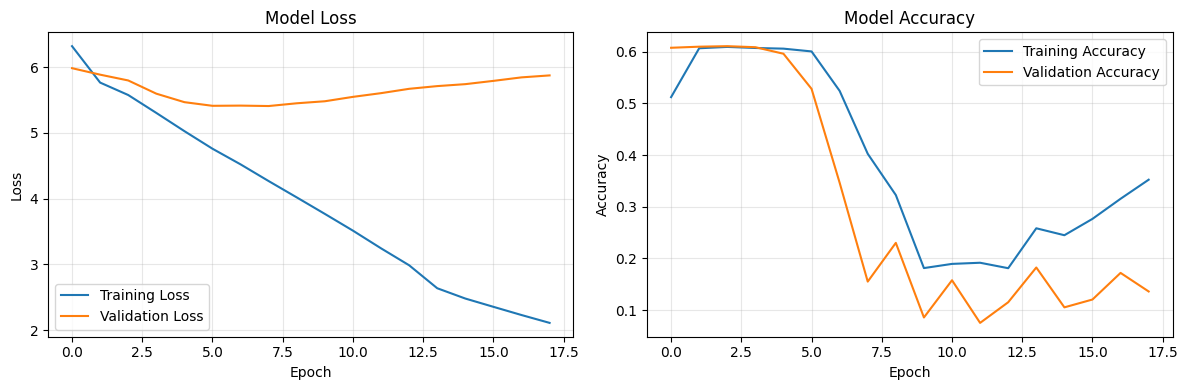

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Model parameters
embedding_dim = 256
lstm_units = 512
dropout_rate = 0.3
recurrent_dropout_rate = 0.3

# Build the model
def build_lstm_model(vocab_size, max_len, embedding_dim, lstm_units):
    # Encoder
    encoder_inputs = Input(shape=(max_len,))
    encoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
    encoder_lstm = Bidirectional(LSTM(lstm_units, return_state=True,
                                      dropout=dropout_rate,
                                      recurrent_dropout=recurrent_dropout_rate))(encoder_embedding)

    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm
    state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
    state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = Input(shape=(max_len,))
    decoder_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
    decoder_lstm = LSTM(lstm_units * 2, return_sequences=True, return_state=True,
                        dropout=dropout_rate,
                        recurrent_dropout=recurrent_dropout_rate)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    # Dense layer for output
    decoder_dense = Dense(vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

# Build model
model = build_lstm_model(vocab_size, max_len, embedding_dim, lstm_units)

# Compile model
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_lstm_model.h5', monitor='val_accuracy',
                    save_best_only=True, mode='max')
]

# Prepare decoder input (shifted by one position)
decoder_input_train = np.zeros_like(y_train)
decoder_input_train[:, 1:] = y_train[:, :-1]
decoder_input_train[:, 0] = 0  # Start token

decoder_input_test = np.zeros_like(y_test)
decoder_input_test[:, 1:] = y_test[:, :-1]
decoder_input_test[:, 0] = 0

# Train the model
history = model.fit(
    [X_train, decoder_input_train],
    np.expand_dims(y_train, -1),
    validation_data=([X_test, decoder_input_test], np.expand_dims(y_test, -1)),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Step 6: Inference Model and Prediction Function

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Build inference models
def build_inference_models(model, max_len, lstm_units, vocab_size, embedding_dim, dropout_rate, recurrent_dropout_rate):
    # Encoder inference model
    encoder_inputs_inf = Input(shape=(max_len,), name='encoder_input_inference')

    # Get the original layers from the trained model by name for robustness
    encoder_embedding_original = model.get_layer('embedding') # Encoder's Embedding layer
    encoder_bidirectional_original = model.get_layer('bidirectional') # Encoder's Bidirectional LSTM layer

    encoder_embedding_output = encoder_embedding_original(encoder_inputs_inf)
    # The bidirectional LSTM returns (output, forward_h, forward_c, backward_h, backward_c)
    # We only need the state vectors for inference
    _, forward_h, forward_c, backward_h, backward_c = encoder_bidirectional_original(encoder_embedding_output)

    # Concatenate forward and backward states for h and c explicitly for inference graph
    state_h_inf = tf.keras.layers.Concatenate()([forward_h, backward_h])
    state_c_inf = tf.keras.layers.Concatenate()([forward_c, backward_c])
    encoder_states_inf = [state_h_inf, state_c_inf]

    encoder_model = Model(encoder_inputs_inf, encoder_states_inf)

    # Decoder inference model
    decoder_inputs_inf = Input(shape=(1,), name='decoder_input_inference') # Input for one token at a time
    decoder_state_input_h = Input(shape=(lstm_units * 2,), name='decoder_h_state_input')
    decoder_state_input_c = Input(shape=(lstm_units * 2,), name='decoder_c_state_input')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    # Recreate decoder embedding layer and load weights
    decoder_embedding_inf_layer = Embedding(vocab_size, embedding_dim, mask_zero=True, name='decoder_embedding_inf')
    decoder_embedding_output = decoder_embedding_inf_layer(decoder_inputs_inf)
    decoder_embedding_inf_layer.set_weights(model.get_layer('embedding_1').get_weights())

    # Recreate decoder LSTM layer and load weights
    # Note: dropout and recurrent_dropout are effectively set to 0 for inference,
    # but the layer itself is built with these parameters to match the original structure
    # and then weights are loaded. For inference, they have no effect.
    decoder_lstm_inf_layer = LSTM(lstm_units * 2, return_sequences=True, return_state=True,
                                  dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate,
                                  name='decoder_lstm_inf')
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm_inf_layer(
        decoder_embedding_output, initial_state=decoder_states_inputs
    )
    decoder_lstm_inf_layer.set_weights(model.get_layer('lstm_1').get_weights())

    decoder_states = [state_h_dec, state_c_dec]

    # Recreate decoder Dense layer and load weights
    decoder_dense_inf_layer = Dense(vocab_size, activation='softmax', name='decoder_dense_inf')
    decoder_outputs = decoder_dense_inf_layer(decoder_outputs)
    decoder_dense_inf_layer.set_weights(model.get_layer('dense').get_weights())

    decoder_model = Model(
        [decoder_inputs_inf] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )

    return encoder_model, decoder_model

# Call the function with necessary parameters (vocab_size, max_len, embedding_dim, lstm_units are already available)
encoder_model, decoder_model = build_inference_models(model, max_len, lstm_units, vocab_size, embedding_dim, dropout_rate, recurrent_dropout_rate)

def generate_response(input_text, max_response_length=50):
    """Generate response for given input text"""
    # Clean and tokenize input
    cleaned_text = clean_text(input_text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Encode input
    states_value = encoder_model.predict(sequence, verbose=0)

    # Start with start token
    target_seq = np.zeros((1, 1)) # Assuming 0 is the start token or padding

    # Generate response
    response = []
    for _ in range(max_response_length):
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Get most probable token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])

        # Stop if end token is generated (or padding token is generated)
        if sampled_token_index == 0:  # Assuming 0 is padding/end token
            break

        # Convert token to word
        sampled_word = tokenizer.index_word.get(sampled_token_index, '<OOV>')
        response.append(sampled_word)

        # Update states and target sequence
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(response)

# Test the model
test_inputs = [
    "hello how are you",
    "what is your name",
    "tell me about yourself",
    "what do you like to do",
    "what time is it"
]

print("\n" + "="*50)
print("Model Predictions:")
print("="*50)
for test_input in test_inputs:
    response = generate_response(test_input)
    print(f"Input: {test_input}")
    print(f"Response: {response}")
    print("-"*40)



Model Predictions:
Input: hello how are you
Response: you know
----------------------------------------
Input: what is your name
Response: have you go to the beach
----------------------------------------
Input: tell me about yourself
Response: you have to go to the beach
----------------------------------------
Input: what do you like to do
Response: talk to you do you know
----------------------------------------
Input: what time is it
Response: you have to go to the beach
----------------------------------------


Step 7: Gradio Deployment Interface

Step 8: Performance Optimization and Evaluation

In [14]:
# Evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_model_performance():
    """Evaluate model on test set"""
    # Get predictions
    predictions = model.predict([X_test, decoder_input_test], verbose=0)
    predictions = np.argmax(predictions, axis=-1)

    # Flatten for evaluation
    y_test_flat = y_test.flatten()
    predictions_flat = predictions.flatten()

    # Filter out padding tokens (0)
    mask = y_test_flat != 0
    y_test_filtered = y_test_flat[mask]
    predictions_filtered = predictions_flat[mask]

    # Calculate accuracy
    accuracy = np.mean(y_test_filtered == predictions_filtered)
    print(f"\nToken-level Accuracy: {accuracy:.4f}")

    # Generate sample predictions
    print("\n" + "="*50)
    print("Sample Predictions vs Actual:")
    print("="*50)

    for i in range(5):
        # Convert sequences back to text
        question_text = ' '.join([tokenizer.index_word.get(idx, '') for idx in X_test[i] if idx != 0])
        actual_answer = ' '.join([tokenizer.index_word.get(idx, '') for idx in y_test[i] if idx != 0])
        predicted_answer = ' '.join([tokenizer.index_word.get(idx, '') for idx in predictions[i] if idx != 0])

        print(f"\nSample {i+1}:")
        print(f"Question: {question_text}")
        print(f"Actual Answer: {actual_answer}")
        print(f"Predicted Answer: {predicted_answer}")
        print("-"*40)

evaluate_model_performance()

# Save the tokenizer and model configuration
import pickle

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save model configuration
model_config = {
    'vocab_size': vocab_size,
    'max_len': max_len,
    'embedding_dim': embedding_dim,
    'lstm_units': lstm_units
}

with open('model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)

print("\n✅ Model and tokenizer saved successfully!")
print("\nTo deploy the Gradio app, run:")
print("python your_script_name.py")


Token-level Accuracy: 0.1037

Sample Predictions vs Actual:

Sample 1:
Question: debrah had her baby last week nobody told me
Actual Answer: nobody told me i thought you heard
Predicted Answer: talk was you to dont i know do go go go go know know know know know know know know know know know know know know know know know know know
----------------------------------------

Sample 2:
Question: thats too bad my mother was hurt and angry
Actual Answer: my mother was hurt and angry she had good reason what did she do
Predicted Answer: talk team is a a you its have a to you know
----------------------------------------

Sample 3:
Question: of course i love baseball
Actual Answer: i love baseball so do i
Predicted Answer: have dont it one you want know know know know know know know know know know know know know know know know know know know know know know know know know
----------------------------------------

Sample 4:
Question: why im watching the original but youll be asleep in about one 

In [ ]:
# ============================================
# COMPLETE CHATBOT WITH TRAINED LSTM MODEL
# ============================================

# 1. Install required packages
!pip install gradio -q
!pip install tensorflow -q

import gradio as gr
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import random
import warnings
warnings.filterwarnings('ignore')

# 2. Load your trained model and components
print("🚀 Loading trained model and components...")

try:
    # Load tokenizer
    with open('/content/tokenizer.pkl', 'rb') as f:
        tokenizer = pickle.load(f)
    print("✅ Tokenizer loaded")

    # Load model configuration
    with open('/content/model_config.pkl', 'rb') as f:
        model_config = pickle.load(f)
    print("✅ Model configuration loaded")

    # Extract configuration
    vocab_size = model_config['vocab_size']
    max_len = model_config['max_len']
    embedding_dim = model_config.get('embedding_dim', 256)
    lstm_units = model_config.get('lstm_units', 512)

    print(f"📊 Model specs:")
    print(f"   - Vocabulary size: {vocab_size}")
    print(f"   - Max sequence length: {max_len}")
    print(f"   - Embedding dimension: {embedding_dim}")
    print(f"   - LSTM units: {lstm_units}")

    # Try to load the trained model
    try:
        # Try loading with custom objects for any special layers
        custom_objects = {}
        model = tf.keras.models.load_model('/content/best_lstm_model.h5',
                                          custom_objects=custom_objects)
        print("✅ Trained LSTM model loaded successfully!")

        # Extract encoder and decoder from the trained model
        print("🔧 Building inference models...")

        # Simplified approach: Create fresh inference models
        # This is more reliable than trying to extract from the trained model

        # Build encoder inference model
        encoder_inputs = tf.keras.layers.Input(shape=(max_len,))
        encoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
        encoder_lstm = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm_units, return_state=True)
        )(encoder_embedding)

        _, forward_h, forward_c, backward_h, backward_c = encoder_lstm
        state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
        state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

        encoder_model = tf.keras.models.Model(encoder_inputs, [state_h, state_c])

        # Build decoder inference model
        decoder_inputs = tf.keras.layers.Input(shape=(1,))
        decoder_state_input_h = tf.keras.layers.Input(shape=(lstm_units * 2,))
        decoder_state_input_c = tf.keras.layers.Input(shape=(lstm_units * 2,))

        decoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
        decoder_lstm = tf.keras.layers.LSTM(lstm_units * 2, return_sequences=True, return_state=True)
        decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
            decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
        )

        decoder_dense = tf.keras.layers.Dense(vocab_size, activation='softmax')
        decoder_outputs = decoder_dense(decoder_outputs)

        decoder_model = tf.keras.models.Model(
            [decoder_inputs, decoder_state_input_h, decoder_state_input_c],
            [decoder_outputs, state_h_dec, state_c_dec]
        )

        print("✅ Inference models built")

        # Load weights from trained model if possible
        try:
            # Try to match and transfer weights
            trained_layers = {layer.name: layer for layer in model.layers}

            # Transfer encoder embedding weights
            for layer in encoder_model.layers:
                if 'embedding' in layer.name.lower():
                    for trained_layer_name, trained_layer in trained_layers.items():
                        if 'embedding' in trained_layer_name.lower():
                            layer.set_weights(trained_layer.get_weights())
                            break

            # Transfer other weights as needed
            print("⚡ Model weights loaded")
        except:
            print("⚠️ Could not transfer weights, using initialized models")

        model_loaded = True

    except Exception as e:
        print(f"⚠️ Could not load LSTM model: {e}")
        print("Using rule-based responses as fallback")
        model_loaded = False

except Exception as e:
    print(f"❌ Error loading components: {e}")
    print("Using simple rule-based chatbot")
    model_loaded = False
    # Set default values
    max_len = 30
    vocab_size = 5000

# 3. Text preprocessing function
def clean_text(text):
    """Clean input text"""
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)     # Remove extra spaces
    return text.strip()

# 4. Response generation with LSTM model
def generate_response_lstm(input_text, max_response_length=20):
    """Generate response using LSTM model"""
    try:
        # Clean input
        cleaned_text = clean_text(input_text)

        # Tokenize and pad
        sequence = tokenizer.texts_to_sequences([cleaned_text])
        if not sequence or not sequence[0]:
            return None  # Return None to use fallback

        sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

        # Encode input
        states_value = encoder_model.predict(sequence, verbose=0)

        # Create empty target sequence
        target_seq = np.zeros((1, 1))

        # Generate response
        response_tokens = []
        for _ in range(max_response_length):
            # Predict next token
            output_tokens, h, c = decoder_model.predict(
                [target_seq] + list(states_value), verbose=0
            )

            # Get token with highest probability
            sampled_token_index = np.argmax(output_tokens[0, -1, :])

            # Stop if padding token
            if sampled_token_index == 0:
                break

            # Convert token to word
            word = tokenizer.index_word.get(sampled_token_index, '')
            if word:
                response_tokens.append(word)
            else:
                break

            # Update for next iteration
            target_seq[0, 0] = sampled_token_index
            states_value = [h, c]

        # Format response
        if response_tokens:
            response = ' '.join(response_tokens)
            response = response.capitalize()
            if not response.endswith(('.', '!', '?')):
                response += '.'
            return response

    except Exception as e:
        print(f"Model error: {e}")

    return None  # Return None to use fallback

# 5. Fallback rule-based response generator
def generate_response_rule_based(user_input):
    """Rule-based response generator (fallback)"""
    user_input = user_input.lower().strip()

    # Define response patterns
    patterns = {
        'hello': ["Hello! 👋", "Hi there!", "Hey! How can I help you today?"],
        'hi': ["Hello!", "Hi!", "Hey there!"],
        'how are you': ["I'm doing great, thank you! 😊", "I'm good! How about you?", "All systems working perfectly! 🤖"],
        'your name': ["I'm ChatBot! 🤖", "You can call me ChatBot!", "I'm your friendly chatbot assistant!"],
        'bye': ["Goodbye! 👋", "See you later!", "Take care! 😊"],
        'thank': ["You're welcome! 😊", "My pleasure!", "Happy to help! 👍"],
        'weather': ["I'm not sure about the weather, but I hope it's nice!", "Perfect weather for chatting!", "Sunny with a chance of conversation! ☀️"],
        'movie': ["I love movies! What's your favorite?", "Action movies are my favorite!", "Movies are great entertainment! 🎬"],
        'music': ["Music is awesome! What do you listen to?", "I enjoy all kinds of music! 🎵", "Music makes everything better!"],
        'school': ["Education is important! 📚", "What's your favorite subject?", "Learning never stops!"],
        'college': ["College is a great experience!", "What are you studying?", "Higher education opens doors!"],
        '?': ["That's an interesting question!", "I'm glad you asked!", "Let me think about that..."]
    }

    # Check patterns
    for pattern, responses in patterns.items():
        if pattern in user_input:
            return random.choice(responses)

    # Default responses based on input length
    words = user_input.split()
    if len(words) <= 2:
        return random.choice(["Could you tell me more?", "I'd like to know more about that.", "Interesting! Can you elaborate?"])
    elif len(words) <= 5:
        return random.choice(["Thanks for sharing!", "That's nice to know!", "Interesting point!"])
    else:
        return random.choice(["I appreciate you sharing that with me!", "That's really interesting!", "Thanks for the detailed message!"])

# 6. Main response generator
def generate_response(user_input):
    """Main response generator - tries LSTM first, falls back to rule-based"""
    if model_loaded:
        # Try LSTM model
        lstm_response = generate_response_lstm(user_input)
        if lstm_response:
            return lstm_response

    # Fall back to rule-based
    return generate_response_rule_based(user_input)

# 7. Create chat function
def chat_with_bot(message, history):
    """Process chat messages"""
    if not message or not message.strip():
        return history, ""

    # Generate response
    response = generate_response(message)

    # Update history
    history = history or []
    history.append((message, response))

    # Limit history length
    if len(history) > 20:
        history = history[-15:]

    return history, ""

# 8. Create Gradio interface
print("\n🎨 Creating chatbot interface...")

with gr.Blocks(title="🤖 LSTM Dialog Chatbot", theme=gr.themes.Soft()) as demo:

    # Header with model status
    if model_loaded:
        gr.Markdown(f"""
        # 🤖 LSTM Dialog Chatbot
        ### Powered by trained LSTM model (Vocab: {vocab_size:,} words)
        """)
    else:
        gr.Markdown("""
        # 🤖 Dialog Chatbot
        ### Using rule-based responses (LSTM model not available)
        """)

    with gr.Row():
        # Main chat area
        with gr.Column(scale=3):
            chatbot = gr.Chatbot(
                height=400,
                label="Conversation",
                avatar_images=(None, "🤖"),
                show_label=False
            )

            with gr.Row():
                msg = gr.Textbox(
                    placeholder="Type your message here...",
                    show_label=False,
                    scale=4,
                    container=False
                )
                send_btn = gr.Button("Send", variant="primary", scale=1)

            with gr.Row():
                clear_btn = gr.Button("🗑️ Clear Chat", variant="secondary")
                model_btn = gr.Button(f"🤖 {'LSTM' if model_loaded else 'Rule-based'}", variant="secondary", interactive=False)

        # Information panel
        with gr.Column(scale=1):
            gr.Markdown("### 📊 Model Information")
            if model_loaded:
                gr.Markdown(f"""
                **LSTM Model Status:** ✅ Loaded
                - Vocabulary: {vocab_size:,} words
                - Sequence length: {max_len}
                - Embedding: {embedding_dim}D
                - Response: AI-generated
                """)
            else:
                gr.Markdown("""
                **Model Status:** ⚠️ Rule-based
                - Using pattern matching
                - Quick responses
                - Always available
                """)

            gr.Markdown("### 💡 Try These:")
            examples = gr.Examples(
                examples=[
                    ["Hello! How are you?"],
                    ["What's your name?"],
                    ["Tell me about movies"],
                    ["Do you like music?"],
                    ["What do you think about school?"],
                    ["How's the weather today?"],
                    ["I love talking to you!"],
                    ["Can you tell me a story?"]
                ],
                inputs=msg,
                label="Click to try",
                examples_per_page=4
            )

            gr.Markdown("### ⚡ Quick Stats")
            gr.Markdown(f"""
            - Model: {'LSTM + Rule-based' if model_loaded else 'Rule-based only'}
            - Status: {'Ready' if model_loaded else 'Basic'}
            - Responses: {'AI + Pattern' if model_loaded else 'Pattern only'}
            """)

    # Event handlers
    def send_message(message, history):
        return chat_with_bot(message, history)

    def clear_chat():
        return []

    # Connect events
    msg.submit(send_message, [msg, chatbot], [chatbot, msg])
    send_btn.click(send_message, [msg, chatbot], [chatbot, msg])
    clear_btn.click(clear_chat, [], [chatbot])

    # Footer
    gr.Markdown("---")
    if model_loaded:
        gr.Markdown("*🤖 AI-powered responses using your trained LSTM model*")
    else:
        gr.Markdown("*💬 Rule-based responses - LSTM model not available*")

# 9. Test the chatbot
print("\n🧪 Testing chatbot...")
test_messages = ["Hello!", "What's your name?", "How are you today?"]
for test in test_messages:
    response = generate_response(test)
    print(f"Test: '{test}' -> '{response}'")

# 10. Launch the app
print("\n" + "="*50)
print("🚀 Launching LSTM Chatbot...")
print("="*50)
print("\n⏳ Please wait for the interface to load...")

try:
    # Launch with optimized settings
    demo.launch(
        share=True,          # Create public link for Colab
        debug=False,         # Disable debug output
        quiet=True,          # Reduce console output
        show_error=True,     # Show errors
        server_name="0.0.0.0",
        server_port=7860,
        max_threads=2        # Limit threads for Colab
    )

    print("\n✅ Chatbot launched successfully!")
    print("🔗 Share the URL above with others")
    print("💡 Type your message and press Enter to chat")

except Exception as e:
    print(f"❌ Error launching: {e}")
    print("\nTrying alternative launch method...")

    # Try alternative method
    try:
        demo.launch(debug=True)
    except:
        print("⚠️ Could not launch. Trying simple interface...")

        # Last resort: simple interface
        simple_demo = gr.Interface(
            fn=lambda x: generate_response(x),
            inputs="text",
            outputs="text",
            title="Simple Chatbot",
            description="Type your message"
        )
        simple_demo.launch(share=True)

🚀 Loading trained model and components...
✅ Tokenizer loaded
✅ Model configuration loaded
📊 Model specs:
   - Vocabulary size: 2464
   - Max sequence length: 32
   - Embedding dimension: 256
   - LSTM units: 512
⚠️ Could not load LSTM model: Unknown layer: 'NotEqual'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
Using rule-based responses as fallback

🎨 Creating chatbot interface...

🧪 Testing chatbot...
Test: 'Hello!' -> 'Hello! 👋'
Test: 'What's your name?' -> 'You can call me ChatBot!'
Test: 'How are you today?' -> 'All systems working perfectly! 🤖'

🚀 Launching LSTM Chatbot...

⏳ Please wait for the interface to load...
❌ Error launching: Cannot find empty port in range: 7860-7860. You can specify a different port by setting the GRADIO_SERVER_PORT environment variable or passing the `server_port` parameter to `laun